## Table of contents

1. [Problem Domain](#Problem-Domain)
2. [CNNs for text classification](#CNNs-for-text-classification)
3. [Loading data and libraries](#Loading-data-and-libraries)
4. [Text preprocessing](#Text-preprocessing)
5. [Architecture](#Architecture)
6. [Training CNN Model](#Training-CNN-Model)
7. [Validation and test set](#Validation-and-test-set)
8. [Bi-GRU with attention model](#Bi-GRU-with-attention-model)
9. [Training RNN model](#Training-RNN-model)
10. [Validation and test set RNN](#Validation-and-test-set-RNN)
11. [Further improvements](#Further-Improvements)


## Problem Domain ##

[Go up](#Table-of-contents)

We always need to compute the similarity in meaning between texts.

*Search engines*
need to model the relevance of a document to a query, beyond the overlap in words between the two. For instance, question-and-answer sites such as Quora or Stackoverflow need to determine whether a question has already been asked before.

In *legal matters*, text similarity task allow to mitigate risks on a new contract, based on the assumption that if a new contract is similar to a existent one that has been proved to be resilient, the risk of this new contract being the cause of financial loss is minimised. Here is the principle of Case Law principle. Automatic linking of related documents ensures that identical situations are treated similarly in every case. Text similarity foster fairness and equality. Precedence retrieval of legal documents is an information retrieval task to retrieve prior case documents that are related to a given case document.

In *customer services*, AI system should be able to understand semantically similar queries from users and provide a uniform response. The emphasis on semantic similarity aims to create a system that recognizes language and word patterns to craft responses that are similar to how a human conversation works. For example, if the user asks “What has happened to my delivery?” or “What is wrong with my shipping?”, the user will expect the same response.


It was used for predicting if one research paper will be cited by the new research paper.

Out of numerous approaches that are available to model this problem depending upon the use case, the text length, content type, domain I experimented with quite a few.

## CNNs for text classification ##

[Go up](#Table-of-contents)
 
-      A ConvNet is able to successfully capture the Spatial and Temporal dependencies in an image through the application of relevant filters.

-       Similar to the Convolutional Layer, the Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant featureswhich are rotational and positional invariant, thus maintaining the process of effectively training of the model.

-       Max Pooling also performs as a Noise Suppressant. It discards the noisy activations altogether and also performs de-noising along with dimensionality reduction. On the other hand, Average Pooling simply performs dimensionality reduction as a noise suppressing mechanism. Hence, we can say that Max Pooling performs a lot better than Average Pooling.

A big argument for CNNs is that they are fast. Very fast. Convolutions are a central part of computer graphics and implemented on a hardware level on GPUs. Compared to something like n-grams, CNNs are also efficient in terms of representation. With a large vocabulary, computing anything more than 3-grams can quickly become expensive. Even Google doesn’t provide anything beyond 5-grams. Convolutional Filters learn good representations automatically, without needing to represent the whole vocabulary. It’s completely reasonable to have filters of size larger than 5. I like to think that many of the learned filters in the first layer are capturing features quite similar (but not limited) to n-grams, but represent them in a more compact way.


How could CNNs be used for text data?

![cnn on text data](http://www.joshuakim.io/wp-content/uploads/2017/12/figure.jpg)

## Loading data and libraries ##

[Go up](#Table-of-contents)

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import Image


import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

import numpy as np
import multiprocessing as mp
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import string
import spacy 
import en_core_web_sm
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
import gc
from sklearn.random_projection import sparse_random_matrix
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, BatchNormalization, GRU,LSTM, Dense, Concatenate,Bidirectional, Conv1D, AveragePooling1D,\
                                                    Lambda, CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,\
                                                    SpatialDropout1D, Dropout, add, concatenate 

from keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.metrics import binary_accuracy
from keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split

from tqdm import tqdm

['fasttext-crawl-300d-2m', 'quora-question-pairs']


Using TensorFlow backend.


In [2]:
train_data = pd.read_csv("../input/quora-question-pairs/train.csv")
test_data = pd.read_csv("../input/quora-question-pairs/test.csv")
embedding_dim = 300
embedding_file_path = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
train_data, val_data, train_y, val_y = train_test_split(train_data[['question1', 'question2']], train_data['is_duplicate'],
                                                        test_size = 0.2,random_state = 999
                                           )

In [3]:
# for loading the word vectors I have used code from this excellent kernel: 
# https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=embedding_file_path):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_embedding_matrix(word_index, embeddings_index, max_features, lower = True, verbose = True):
    embedding_matrix = np.zeros((max_features, 300))
    for word, i in tqdm(word_index.items(),disable = not verbose):
        if lower:
            word = word.lower()
        if i >= max_features: continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            embedding_vector = embeddings_index["unknown"]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [4]:
maxlen = 20
vocab_size = 10000

In [5]:
#This is very generic list of contractions and most of the words may not even appear in an item description
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", 
                "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                "you're": "you are", "you've": "you have" }


## Text preprocessing ##

[Go up](#Table-of-contents)

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 contractions={},
                 stop_words={},
                 spellings={},
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. contractions
            3. Punctuation removal
            4. Stop words removal - words like not are excluded from stop words
        """
       
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs
        self.contractions = contractions
        self.stop_words = stop_words
        self.spellings = spellings
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)   # split data for parallel processing
        pool = mp.Pool(cores)                           # create pools
        data = pd.concat(pool.map(self._preprocess_part, data_split))   # concatenate results
        pool.close()                                  
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        lowercase_text = self._lowercase(text)
        expanded_contractions = self._expand_contactions(lowercase_text)
        
        return (expanded_contractions)
   
    def _lowercase(self, text):
        return text.lower()
        
    def _expand_contactions(self, doc):
        new_text = ""
        for t in doc.split():
            if (t in string.punctuation) or (t in self.stop_words) or (t in string.punctuation):
                continue
            if t in contractions:
                new_text = new_text + " " + (contractions[t])
            else: 
                new_text = new_text + " " + t
        return new_text


In [7]:
refined_stop_words = stop_words.ENGLISH_STOP_WORDS - {"not", "none", "nothing", "nowhere", "never", "cannot",
                                "cant", "couldnt", "except", "hasnt", "neither", "no", 
                                 "nobody", "nor", "without", "when", "why","whom","who","what","where","how"}

In [8]:
%time

train_data["question1"] = train_data["question1"].fillna("None")
train_data["question2"] = train_data["question2"].fillna("None")
val_data["question1"] = val_data["question1"].fillna("None")
val_data["question2"] = val_data["question2"].fillna("None")
test_data["question1"] = test_data["question1"].fillna("None")
test_data["question2"] = test_data["question2"].fillna("None")


train_data['question1'] = train_data['question1'].astype(str)
train_data['question2'] = train_data['question2'].astype(str)
val_data['question1'] = val_data['question1'].astype(str)
val_data['question2'] = val_data['question2'].astype(str)
test_data['question1'] = test_data['question1'].astype(str)
test_data['question2'] = test_data['question2'].astype(str)

textPreprocessor = TextPreprocessor(n_jobs=-1, contractions=contractions,
                 stop_words=refined_stop_words)
    
train_data['question1'] = textPreprocessor.transform(train_data['question1'])
train_data['question2'] = textPreprocessor.transform(train_data['question2'])
val_data['question1'] = textPreprocessor.transform(val_data['question1'])
val_data['question2'] = textPreprocessor.transform(val_data['question2'])
test_data['question1'] = textPreprocessor.transform(test_data['question1'])
test_data['question2'] = textPreprocessor.transform(test_data['question2'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [9]:
#intsantiate the tokenizer
tokenize = Tokenizer(num_words = vocab_size, oov_token='OOV')
tokenize.fit_on_texts(np.hstack([train_data['question1'], train_data['question2'],
                                 test_data['question1'],test_data['question2']]))
vocabulary = tokenize.word_index

# sentences to sequences
train_data['sequence_1'] = tokenize.texts_to_sequences(train_data['question1'])
train_data['sequence_2'] = tokenize.texts_to_sequences(train_data['question2'])
val_data['sequence_1'] = tokenize.texts_to_sequences(val_data['question1'])
val_data['sequence_2'] = tokenize.texts_to_sequences(val_data['question2'])
test_data['sequence_1'] = tokenize.texts_to_sequences(test_data['question1'])
test_data['sequence_2'] = tokenize.texts_to_sequences(test_data['question2'])

train_padded = {}
test_padded = {}
val_padded = {}

train_padded['sequence_1'] = pad_sequences(train_data['sequence_1'], maxlen = maxlen)
train_padded['sequence_2'] = pad_sequences(train_data['sequence_2'], maxlen = maxlen)
val_padded['sequence_1'] = pad_sequences(val_data['sequence_1'], maxlen = maxlen)
val_padded['sequence_2'] = pad_sequences(val_data['sequence_2'], maxlen = maxlen)
test_padded['sequence_1'] = pad_sequences(test_data['sequence_1'], maxlen = maxlen)
test_padded['sequence_2'] = pad_sequences(test_data['sequence_2'], maxlen = maxlen)

In [10]:
embeddings_index = load_embeddings()
embedding_matrix = build_matrix(tokenize.word_index, embeddings_index)
del embeddings_index
#gc.collect()

2000001it [02:56, 11323.52it/s]


In [11]:
# I'm also tracking auc, to understand how well this model might be able to separate the two classes
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


## Architecture ##

[Go up](#Table-of-contents)

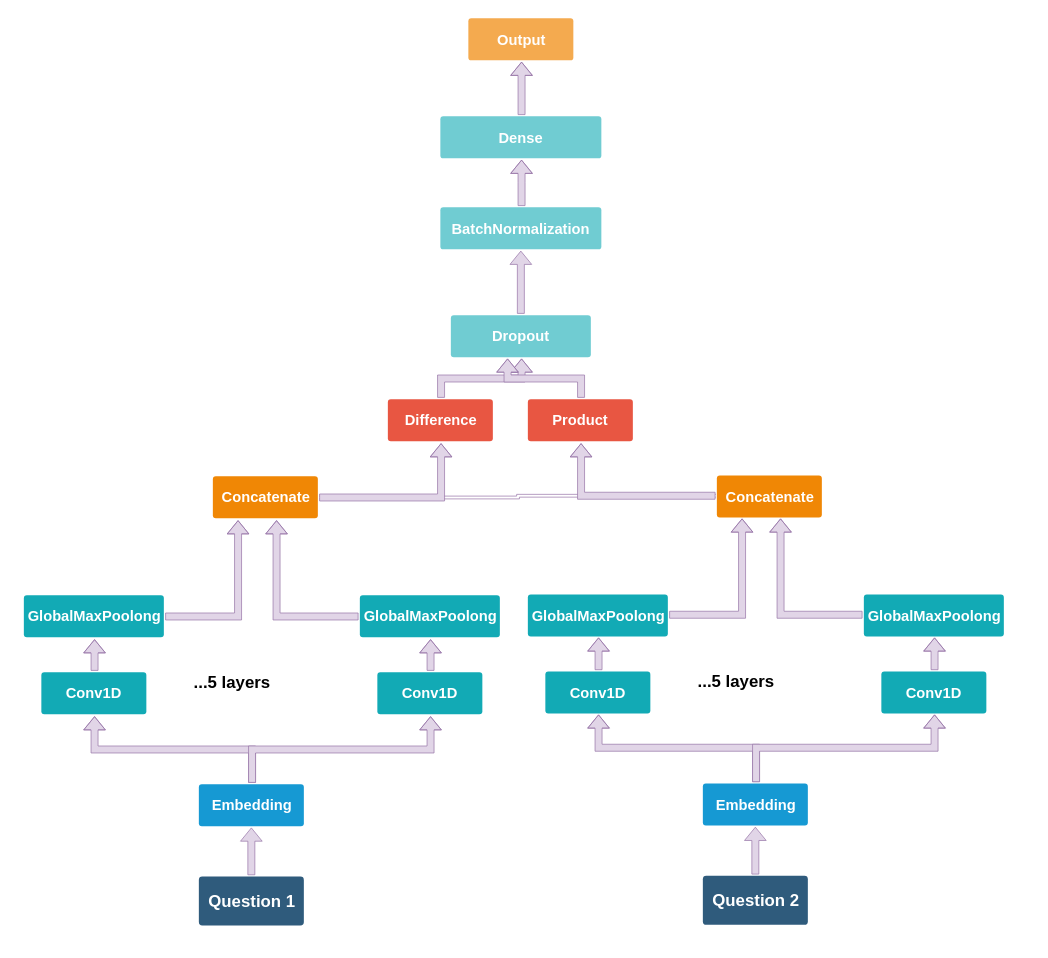

In [12]:
# CNN model with maxpool and fasttext word embeddings

def CNN_Model(emb_matrix):
    emb_layer = Embedding(
        input_dim=emb_matrix.shape[0],
        output_dim=emb_matrix.shape[1],
        weights=[emb_matrix],
        input_length=maxlen,
        trainable=False
    )
    
    # 1D convolutions that can iterate over the word vectors
    conv1 = Conv1D(filters=128, kernel_size=1, padding='same', activation='relu')
    conv2 = Conv1D(filters=128, kernel_size=2, padding='same', activation='relu')
    conv3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')
    conv4 = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')
    conv5 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')
    conv6 = Conv1D(filters=32, kernel_size=6, padding='same', activation='relu')


    # Define inputs
    seq1 = Input(shape=(maxlen,))
    seq2 = Input(shape=(maxlen,))

    # Run inputs through embedding
    emb1 = emb_layer(seq1)
    emb2 = emb_layer(seq2)

    # Run through CONV + GAP layers
    conv1a = conv1(emb1)
    glob1a = GlobalMaxPooling1D()(conv1a)
    conv1b = conv1(emb2)
    glob1b = GlobalMaxPooling1D()(conv1b)

    conv2a = conv2(emb1)
    glob2a = GlobalMaxPooling1D()(conv2a)
    conv2b = conv2(emb2)
    glob2b = GlobalMaxPooling1D()(conv2b)

    conv3a = conv3(emb1)
    glob3a = GlobalMaxPooling1D()(conv3a)
    conv3b = conv3(emb2)
    glob3b = GlobalMaxPooling1D()(conv3b)

    conv4a = conv4(emb1)
    glob4a = GlobalMaxPooling1D()(conv4a)
    conv4b = conv4(emb2)
    glob4b = GlobalMaxPooling1D()(conv4b)

    conv5a = conv5(emb1)
    glob5a = GlobalMaxPooling1D()(conv5a)
    conv5b = conv5(emb2)
    glob5b = GlobalMaxPooling1D()(conv5b)

    conv6a = conv6(emb1)
    glob6a = GlobalMaxPooling1D()(conv6a)
    conv6b = conv6(emb2)
    glob6b = GlobalMaxPooling1D()(conv6b)

    mergea = concatenate([glob1a, glob2a, glob3a, glob4a, glob5a, glob6a])
    mergeb = concatenate([glob1b, glob2b, glob3b, glob4b, glob5b, glob6b])

    # We take the explicit absolute difference between the two sentences
    # Furthermore we take the multiply different entries to get a different measure of equalness
    diff = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=(4 * 128 + 2*32,))([mergea, mergeb])
    mul = Lambda(lambda x: x[0] * x[1], output_shape=(4 * 128 + 2*32,))([mergea, mergeb])
    
    # Merge the Magic and distance features with the difference layer
    merge = concatenate([diff, mul])

    # The MLP that determines the outcome
    x = Dropout(0.2)(merge)
    x = BatchNormalization()(x)
    x = Dense(300, activation='relu')(x)

    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(100, activation='relu', )(x)

    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    pred = Dense(1, activation='sigmoid')(x)

    # model = Model(inputs=[seq1, seq2, magic_input, distance_input], outputs=pred)
    model = Model(inputs=[seq1, seq2], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', auroc])

    return model

In [13]:
cnn_model = CNN_Model(embedding_matrix)
cnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      39264300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 128)      38528       embedding_1[0][0]                
          

## Training CNN Model ##

[Go up](#Table-of-contents)

In [14]:
cnn_model.fit([train_padded['sequence_1'],train_padded['sequence_2']], train_y, class_weight={0:0.64,1:0.36}, epochs = 2)

Epoch 1/2
323432/323432 [==============================] - 600s 2ms/step - loss: 0.2010 - acc: 0.7788 - auroc: 0.8776
Epoch 2/2
 35328/323432 [==>...........................] - ETA: 8:50 - loss: 0.1775 - acc: 0.8126 - auroc: 0.9122

## Validation and test set ##

[Go up](#Table-of-contents)

In [15]:
val_preds = cnn_model.predict([val_padded['sequence_1'], val_padded['sequence_2']])
cnn_model.evaluate([val_padded['sequence_1'], val_padded['sequence_2']], val_y)
submission = pd.DataFrame(index = val_data.index, columns = ['cv_id', 'is_duplicate'])
submission['val_id'] = val_data.index
submission['is_duplicate'] = val_preds
submission.to_csv('val_conv_submission.csv', index=False)

80858/80858 [==============================] - 57s 709us/step


In [16]:
cnn_predictions = cnn_model.predict([test_padded['sequence_1'],test_padded['sequence_2']])
submission = pd.DataFrame(index = test_data.index, columns = ['test_id', 'is_duplicate'])
submission['test_id'] = test_data.index
submission['is_duplicate'] = cnn_predictions
submission.to_csv('conv_submission.csv', index=False)

## Bi-GRU with attention model ##

[Go up](#Table-of-contents)

In [17]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb
from keras.layers import *
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [18]:
def RNN_Model(embedding_matrix):
    input_1 = Input(shape=(maxlen,))
    input_2 = Input(shape=(maxlen,))
    
    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False)
    
    gru_layer = Bidirectional(GRU(64, return_sequences=True))
    
    attention_layer = Attention(maxlen)
    attention_output_1 = attention_layer(gru_layer(embedding_layer(input_1)))
    attention_output_2 = attention_layer(gru_layer(embedding_layer(input_2)))
    
    
    concat_layer = concatenate([attention_output_1, attention_output_2])
    
    x = Dropout(0.2)(concat_layer)
    x = BatchNormalization()(x)
    x = Dense(300, activation='relu')(x)

    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    pred = Dense(1, activation='sigmoid')(x)

    model = Model([input_1,input_2],pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model
    

In [19]:
rnn_model = RNN_Model(embedding_matrix)
rnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      39264300    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 128)      140160      embedding_2[0][0]                
          

## Training RNN model ##

[Go up](#Table-of-contents)

In [20]:
rnn_history = rnn_model.fit([train_padded['sequence_1'],train_padded['sequence_2']], train_y, class_weight={0:0.64,1:0.36},
             validation_data=([val_padded['sequence_1'], val_padded['sequence_2']], val_y), verbose=1, epochs = 2)

Train on 323432 samples, validate on 80858 samples
Epoch 1/2
323432/323432 [==============================] - 583s 2ms/step - loss: 0.2389 - acc: 0.7197 - val_loss: 0.4639 - val_acc: 0.7666
Epoch 2/2
 86816/323432 [=======>......................] - ETA: 6:29 - loss: 0.2156 - acc: 0.7539

## Validation and test set RNN ##

[Go up](#Table-of-contents)

In [21]:
%%time
val_preds = rnn_model.predict([val_padded['sequence_1'], val_padded['sequence_2']])
print(rnn_model.evaluate([val_padded['sequence_1'], val_padded['sequence_2']], val_y))
submission = pd.DataFrame(index = val_data.index, columns = ['cv_id', 'is_duplicate'])
submission['val_id'] = val_data.index
submission['is_duplicate'] = val_preds
submission.to_csv('val_rnn_submission.csv', index=False)

80858/80858 [==============================] - 50s 618us/step
[0.4297571598786144, 0.7898909198886644]
CPU times: user 4min 43s, sys: 50.5 s, total: 5min 34s
Wall time: 1min 39s


In [22]:
%%time
rnn_predictions = rnn_model.predict([test_padded['sequence_1'],test_padded['sequence_2']])
submission = pd.DataFrame(index = test_data.index, columns = ['test_id', 'is_duplicate'])
submission['test_id'] = test_data.index
submission['is_duplicate'] = rnn_predictions
submission.to_csv('rnn_submission.csv', index=False)

CPU times: user 1h 8min 14s, sys: 12min 4s, total: 1h 20min 19s
Wall time: 23min 43s


## Further improvements ##

[Go up](#Table-of-contents)

1. Tfidf weighted word embeddings for everything
2. fuzzy features